In [13]:
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as accuracy
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

## Загрузка датасетов

In [14]:
load_path = "/content/drive/MyDrive/Университет/NLP/lab2-rnn_many2one/tensors1.pt"
tensors = torch.load(load_path, weights_only=True)

In [15]:
float32 = torch.float32
xtrain, ytrain = tensors['xtrain'].type(float32), tensors['ytrain'].type(float32)
xtest, ytest = tensors['xtest'].type(float32), tensors['ytest'].type(float32)
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

(torch.Size([3030, 300]),
 torch.Size([3030, 4]),
 torch.Size([535, 300]),
 torch.Size([535, 4]))

In [16]:
ytest_class_labels = ytest.max(axis=1).indices
ytest_class_labels[:5]

tensor([2, 0, 1, 0, 0])

In [17]:
train_dataset = TensorDataset(xtrain, ytrain)

## Метод обучения модели

In [ ]:
class ModelTrainer:
    def __init__(self, xtrue, ytrue) -> None:
        self.xtrue = xtrue
        self.ytrue = ytrue
        self.loss_values = []
        self.accuracy = []

    def fit(self, model, dataloader, loss, optimizer, scheduler = None, n_epoh = 100) -> None:
        for _ in tqdm(range(n_epoh), desc="Epoh"):
            for xbatch, ybatch in tqdm(dataloader, desc="Batch", leave=False):
                optimizer.zero_grad()
                predict = model(xbatch)
                loss_value = loss(ybatch, predict)
                loss_value.backward()
                optimizer.step()
                if scheduler:
                    scheduler.step()
            epoh_predict = model(self.xtrue).max(axis=1).indices
            self.accuracy.append(accuracy(self.ytrue, epoh_predict))
            self.loss_values.append(loss_value.item())


## Модель RNN

In [25]:
torch.manual_seed(2024)

class RNNModel(nn.Module):
    def __init__(self, rnn_in_size, rnn_out_size, num_layers, lin_out_size) -> None:
        super(RNNModel, self).__init__()
        self.num_layers = num_layers
        self.rnn_out_size = rnn_out_size
        self.rnn = nn.RNN(rnn_in_size, rnn_out_size, num_layers)
        self.lin = nn.Linear(rnn_out_size, lin_out_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h0 = torch.zeros(self.num_layers, self.rnn_out_size)
        y, hn = self.rnn(x, h0)
        y = nn.LeakyReLU()(self.lin(y))
        y = nn.Softmax(dim=-1)(y)
        return y

## Обучение RNN

In [ ]:
# params

# model
rnn_in_size = xtrain.shape[1] # 300
rnn_out_size = 148
num_layers = 2
lin_out_size = ytrain.shape[1] # 4

# dataloader
batch_size = 128

# optimizer
lr = 1e-4

# scheduler
T_max = 30

# trainer
n_epoh = 50

model = RNNModel(rnn_in_size, rnn_out_size, num_layers, lin_out_size)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)

loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

trainer = ModelTrainer(xtest, ytest_class_labels)
trainer.fit(model, train_dataloader, loss, optimizer, scheduler, n_epoh=n_epoh)

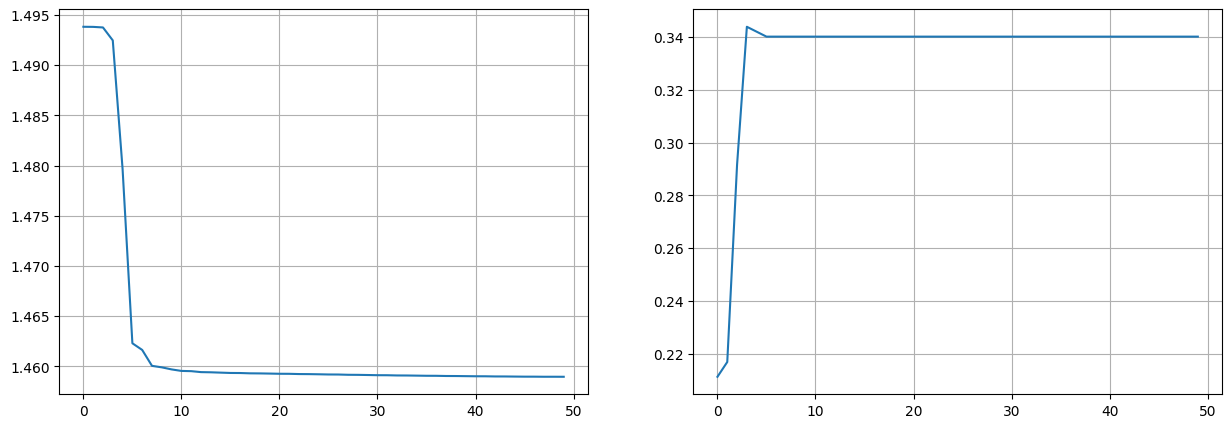

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.grid(True)
ax1.plot(trainer.loss_values)

ax2.grid(True)
ax2.plot(trainer.accuracy)

## Модель LSTM

In [29]:
torch.manual_seed(2024)

class LSTMModel(nn.Module):
    def __init__(self, lstm_in_size, lstm_out_size, num_layers, lin_out_size) -> None:
        super(LSTMModel, self).__init__()
        self.lstm_out_size = lstm_out_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(lstm_in_size, lstm_out_size, num_layers)
        self.lin = nn.Linear(lstm_out_size, lin_out_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h0 = torch.randn(self.num_layers, self.lstm_out_size)
        c0 = torch.randn(self.num_layers, self.lstm_out_size)
        y, (hn, cn) = self.lstm(x, (h0, c0))
        y = nn.LeakyReLU()(self.lin(y))
        y = nn.Softmax(dim=-1)(y)
        return y

In [ ]:
# params

# model
lstm_in_size = xtrain.shape[1] # 300
lstm_out_size = 148
num_layers = 1
lin_out_size = ytest.shape[1] # 4

# dataloader
batch_size = 128

# optimizer
lr = 1e-3

# scheduler
T_max = 30

# trainer
n_epoh = 50

model = LSTMModel(lstm_in_size, lstm_out_size, num_layers, lin_out_size)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)

loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

trainer = ModelTrainer(xtest, ytest_class_labels)
trainer.fit(model, train_dataloader, loss, optimizer, scheduler=None, n_epoh=n_epoh)

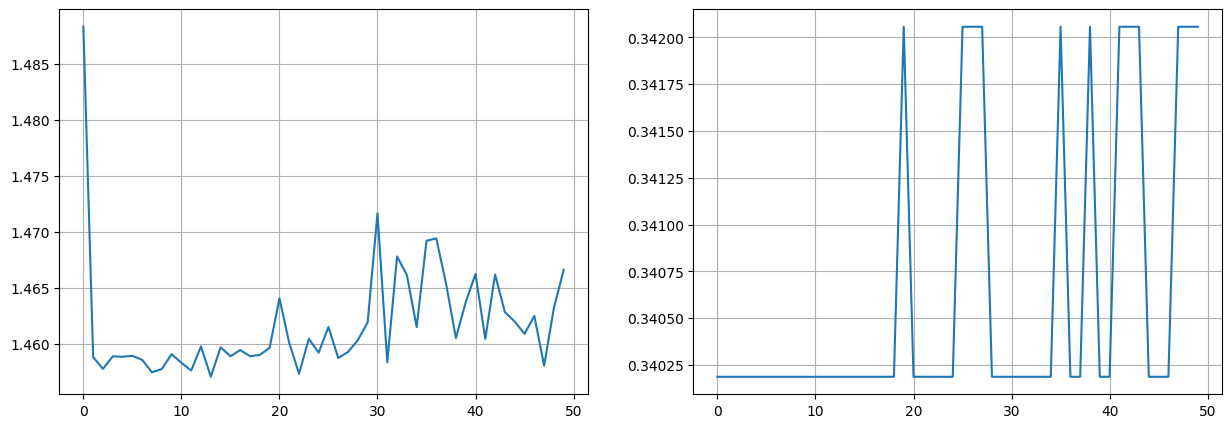

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.grid(True)
ax1.plot(trainer.loss_values)

ax2.grid(True)
ax2.plot(trainer.accuracy)

## Модель GRU

In [39]:
torch.manual_seed(2024)

class GRUModel(nn.Module):
    def __init__(self, gru_in_size, gru_out_size, num_layers, lin_out_size) -> None:
        super(GRUModel, self).__init__()
        self.gru_out_size = gru_out_size
        self.num_layers = num_layers
        self.gru = nn.GRU(gru_in_size, gru_out_size, num_layers)
        self.lin = nn.Linear(gru_out_size, lin_out_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h0 = torch.randn(self.num_layers, self.gru_out_size)
        y, hn = self.gru(x, h0)
        y = nn.LeakyReLU()(self.lin(y))
        y = nn.Softmax(dim=-1)(y)
        return y

In [ ]:
# params

# model
gru_in_size = xtrain.shape[1]
gru_out_size = 148
num_layers = 1
lin_out_size = 4

# dataloader
batch_size = 128

# optimizer
lr = 1e-3

# scheduler
T_max = 30

# trainer
n_epoh = 50

model = GRUModel(gru_in_size, gru_out_size, num_layers, lin_out_size)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=False)

loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

trainer = ModelTrainer(xtest, ytest_class_labels)
trainer.fit(model, train_dataloader, loss, optimizer, scheduler, n_epoh)

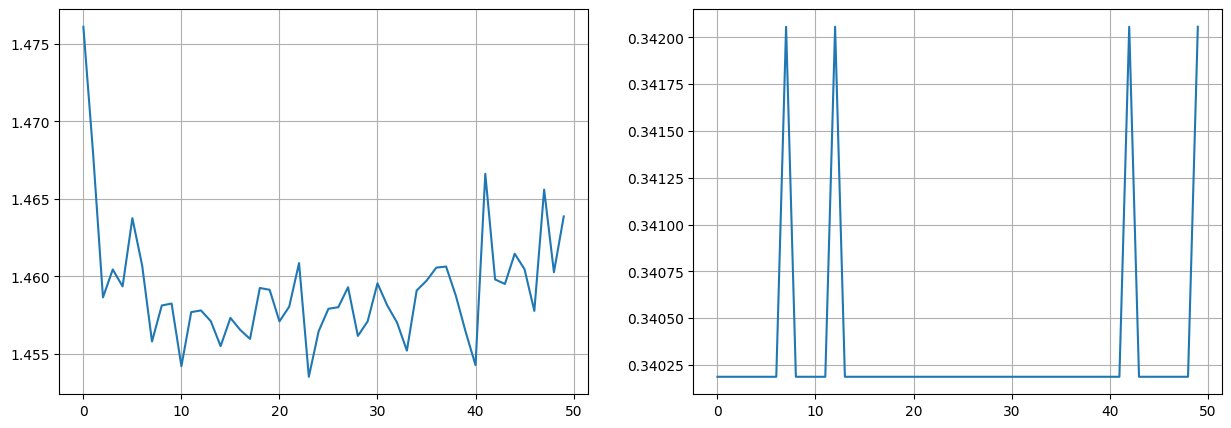

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.grid(True)
ax1.plot(trainer.loss_values)

ax2.grid(True)
ax2.plot(trainer.accuracy)